# Compute Network Permeability

There are three main stages of an OpenPNM simulation. 

1. Create a network topology and define geometric properties
2. Create a phase object and define pore-scale transport properties
3. Create an algorithm object, assign boundary conditions, and run it

Let's proceed as though we're going to do a single phase flow simulation to compute the permeability of the network.

One common conductance model for flow through a tube is the Hagan-Poiseuille model:

$$ Q = \frac{\pi R^4}{8 \mu L} \Delta P = g_H \Delta P $$

From this we can see that our simulation will need the diameters and lengths of pores and throats, as well as the fluid viscosity.

## Network Generators

OpenPNM includes a number of ways to [generate networks](https://openpnm.org/modules/generated/openpnm.network.html#module-openpnm.network), both regular lattices and random networks:

In [56]:
import openpnm as op
for item in dir(op.network):
    if not item.startswith('_'):
        print(item)
        

BodyCenteredCubic
Cubic
CubicTemplate
Delaunay
DelaunayVoronoiDual
Demo
FaceCenteredCubic
Network
Voronoi


Let's use the Cubic generator, and stick to 2D, for simplicity:

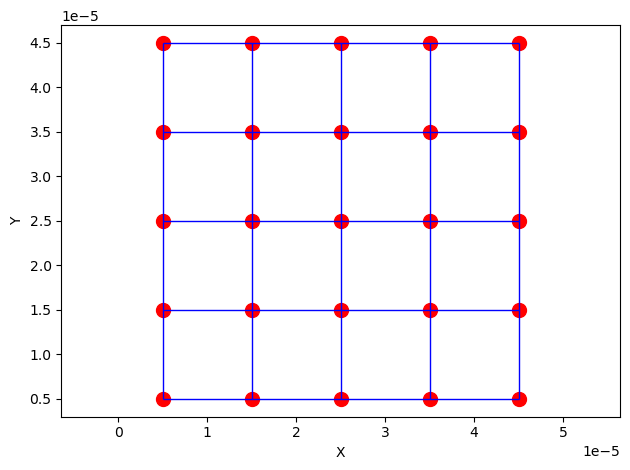

In [57]:
pn = op.network.Cubic(shape=[5, 5, 1], spacing=1e-5)
ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, s=100, ax=ax)


## Data Storage

Let's print the network and see what data is created during the generation:

In [28]:
print(pn)



══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x2761b786ea0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                       25 / 25
  3  throat.conns                                                      40 / 40
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.surface                                                           16
  3  throat.surface                                                         16
  4  pore.left                                                               5
  5 

Key things to note:
1. Each item listed above is an entry in the ``pn`` dictionary, like ``pn['pore.coords']``
2. Items starting with the word ``'pore'`` are obviously "pore data" and ``'throat'`` indicates "throat data"
3. Each item is a numpy array with one element for each pore or throat...this network has 25 pores and 40 throats
4. 'pore.coords' lists the [x, y, z] coordinates of each pore
5. 'throat.conns' lists the [head, tail] of each throat, meaning which pore is on each end
6. The things referred to as "Labels" are boolean arrays (i.e. ``True/False``) where ``True`` indicates where that label is applied.  (These are very helpful for applying boundary conditions). 
7. Geometrical data is missing, but we'll add that next

## Define Geometry

To conduct our simulation we need: 

- The diameter of pores and throats
- The length of throats

### Pore Diameters: The easy way

Let's assign pore diameters from a unform distribution, remembering that the pores are spaced 10 um apart and they should not overlap:

In [86]:
import numpy as np
pn['pore.diameter'] = np.random.rand(pn.num_pores())*1e-5
print(pn['pore.diameter'])


[7.62352084e-06 4.18667497e-07 2.78986473e-06 8.57960414e-06
 3.69039996e-06 8.98991875e-06 2.89097831e-06 3.80323481e-06
 1.09373393e-06 8.14624611e-06 9.33485442e-06 1.83107189e-06
 3.11198567e-06 6.74704043e-06 7.91010422e-07 3.27239943e-07
 3.26575619e-06 3.86612194e-06 5.48967345e-06 5.52931172e-06
 3.30127174e-06 4.25651101e-06 2.51856859e-06 2.02635132e-06
 7.77525513e-06]


### Throat Lengths: The hard way

First, let's do this by hand:

> We'll use the ``'throat.conns'`` array to index into the ``'pore.diameter'`` array to get the diameter of the pore on each end of each throat, then we'll subtract half of each diameter from the known pore spacing, with the remaining amount being the throat length

In [59]:
D1, D2 = pn['pore.diameter'][pn['throat.conns']].T
Lt = 1e-5 - D1/2 - D2/2
print(Lt)


[3.38614765e-06 2.66129569e-06 2.68908581e-06 6.21639964e-06
 6.77185282e-06 6.01354562e-06 5.27774603e-06 4.47143498e-06
 5.42389468e-06 7.11133557e-06 5.28112350e-06 1.37637822e-06
 3.18933525e-06 3.12918888e-06 2.74284317e-06 2.70295620e-06
 5.95339764e-06 2.11642329e-06 5.28608824e-06 8.91380333e-06
 3.34892736e-06 6.80907310e-06 1.86576821e-06 6.10106364e-06
 4.58677099e-06 4.67340213e-06 7.52234536e-06 5.60253583e-06
 4.95633370e-06 8.91479500e-07 4.15921814e-06 4.45401178e-06
 5.78651267e-06 2.23745401e-06 1.84188042e-06 5.81224492e-06
 3.33048797e-06 1.91512421e-06 6.11380720e-06 5.50295233e-06]


### Throat Lengths: The "pore-scale model" way

Calculations like the one above are common, so OpenPNM offers pre-defined ways to do them.  

``openpnm.models`` is a libary of prewritting functions for computing many things.  

The library is further organized by the type of thing being computed, such as ``openpnm.models.geometry`` and ``openpnm.models.physics``.

In [75]:
mod = op.models.geometry.throat_length.squares_and_rectangles
pn.add_model(propname='throat.length', model=mod)
pn.regenerate_models()
print(pn['throat.length'])


[3.38614765e-06 2.66129569e-06 2.68908581e-06 6.21639964e-06
 6.77185282e-06 6.01354562e-06 5.27774603e-06 4.47143498e-06
 5.42389468e-06 7.11133557e-06 5.28112350e-06 1.37637822e-06
 3.18933525e-06 3.12918888e-06 2.74284317e-06 2.70295620e-06
 5.95339764e-06 2.11642329e-06 5.28608824e-06 8.91380333e-06
 3.34892736e-06 6.80907310e-06 1.86576821e-06 6.10106364e-06
 4.58677099e-06 4.67340213e-06 7.52234536e-06 5.60253583e-06
 4.95633370e-06 8.91479500e-07 4.15921814e-06 4.45401178e-06
 5.78651267e-06 2.23745401e-06 1.84188042e-06 5.81224492e-06
 3.33048797e-06 1.91512421e-06 6.11380720e-06 5.50295233e-06]


### Throat Diameters: The "pore-scale model" way

Calculating throat diameters by hand is also tedious because we'd like to ensure they are not larger than their neighboring pores. 

Luckily there is a pore-scale model for that:

In [76]:
mod = op.models.geometry.throat_size.from_neighbor_pores
pn.add_model(propname='throat.diameter', model=mod)
pn.regenerate_models()


## Compute Phase Properties

There are several ways to compute phase properties, but for the sake of this tutorial we'll just do it the quick and easy way.

In [79]:
water = op.phase.Phase(network=pn)
water['pore.viscosity'] = 0.001  # Pa.s
water['throat.viscosity'] = 0.001


Things to note:

- We assigned a scalar value (0.001), but internally OpenPNM applies it to all pores and throats so that each has its own value
- We have assigned values to both pores *and* throats, but OpenPNM would have automatically interpolate one if it only had the other

## Compute the Hydraulic Conductance

For simplicity, we will assume that all the pressue drop occurs in the throats, so we will not consider the contribution of the pores.

So:

$$ \frac{1}{g_H} = \frac{1}{g_{p,1}} + \frac{1}{g_t} + \frac{1}{g_{p,2}} = \frac{1}{\infty} + \frac{1}{g_t} + \frac{1}{\infty} = \frac{1}{g_t}$$

In [81]:
R = pn['throat.diameter']/2
L = pn['throat.length']
mu = water['throat.viscosity']
water['throat.hydraulic_conductance'] = np.pi * R**4 / (8 * mu * L )


## Run the Simulation

Now we create a ``StokesFlow`` object, assign boundary conditions and run it.

Note that the ``StokesFlow`` algorithm automatically looks for values of ``'throat.hydraulic_conductance'`` on the ``Phase`` object.  

In [82]:
sf = op.algorithms.StokesFlow(network=pn, phase=water)


### Applying Boundary Conditions Using Labels

The labels mentioned above will now be of great help.  They allow us to choose pores on the desired faces for inlet and outlet boundaries.

We can ask the network to return the indices of the pores which have been labelled "left":

In [83]:
print(pn.pores('left'))


[0 1 2 3 4]


Now we use these to specify boundary conditions:

In [84]:
sf.set_value_BC(pores=pn.pores("left"), values=200_000)
sf.set_value_BC(pores=pn.pores("right"), values=100_000)


And finally we are ready to run it:

In [85]:
sf.run()


## Determine Darcy Permeability of the Network

The simulation performed above is equivalent to the experiment that one would conduct on a real sample.

We just need to ask OpenPNM what was the total flow rate across the network, then we can find $K$ from:

$$ Q = \frac{K A}{\mu L} \Delta P $$

In [92]:
L = 5*1e-5
A = (5 * 1) * (1e-5)**2
mu = 0.001
DeltaP = 100_000


In [93]:
Q = sf.rate(pores=pn.pores('left'), mode='group')


In [95]:
K = Q * mu * L / (A * DeltaP)
print("The Darcy permeability is: ", K, "m^2")


The Darcy permeability is:  [1.35291722e-13] m^2
